In [16]:
# Extract files in a subfolder
!echo "__TAR__B64__GOES__HERE__" \
    | base64 -d \
    | tar -xvzf -

select/Makefile
select/benchmark.c
select/select.c
select/test.c
select/test.h


In [2]:
!git clone https://github.com/google/benchmark.git

Cloning into 'benchmark'...
remote: Enumerating objects: 8850, done.
remote: Counting objects: 100% (1447/1447), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 8850 (delta 1293), reused 1274 (delta 1195), pack-reused 7403 (from 1)
Receiving objects: 100% (8850/8850), 2.80 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (5960/5960), done.


In [3]:
!cd benchmark && \
  git checkout 761305ec3b33abf30e08d50eb829e19a802581cc && \
  cmake -E make_directory "build" && \
  cmake -E chdir "build" cmake -DBENCHMARK_DOWNLOAD_DEPENDENCIES=on -DCMAKE_BUILD_TYPE=Release ../ && \
  cmake --build "build" --config Release

Note: switching to '761305ec3b33abf30e08d50eb829e19a802581cc'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 761305e Update user_guide.md (#1863)
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Failed to find LLVM FileCheck
-- Found Git: /usr/bin/git (found version "2.34.1")
-- Google Benchmark vers

In [17]:
!cd select && make test

g++ -O0 -fno-omit-frame-pointer -fsanitize=undefined -fsanitize=address -g select.c test.c -o test.out
./test.out 
PASS '(less than 5)'
    expected 4, got deterministic 4 and rand 4, sorted arr: {3, 4, 4, 4, 4, }
PASS '(less than 5)'
    expected 12, got deterministic 12 and rand 12, sorted arr: {3, 12, 50, 84, }
PASS '(less than 5, last element)'
    expected 84, got deterministic 84 and rand 84, sorted arr: {3, 12, 50, 84, }
PASS '(len % 5 == 1)'
    expected 12, got deterministic 12 and rand 12, sorted arr: {2, 3, 9, 12, 50, 84, }
PASS '(len % 5 == 2)'
    expected 15, got deterministic 15 and rand 15, sorted arr: {3, 7, 11, 12, 15, 17, 23, 50, 60, 81, 84, 98, }
PASS '(len % 5 == 3)'
    expected 15, got deterministic 15 and rand 15, sorted arr: {2, 3, 7, 9, 11, 12, 15, 23, 50, 60, 81, 84, 98, }
PASS '(len % 5 == 4)'
    expected 7, got deterministic 7 and rand 7, sorted arr: {2, 3, 7, 9, 11, 12, 15, 17, 23, 50, 60, 81, 84, 98, }
PASS 'ends up in the lower part of recursion'
    ex

g++ -O2 select.c benchmark.c -std=c++11 -isystem ../benchmark/include -L../benchmark/build/src -lbenchmark -lpthread -o benchmark.out
taskset -c 0 \
	./benchmark.out \
	--benchmark_out=benchmark.json \
	--benchmark_out_format=json \
	--benchmark_enable_random_interleaving=true \
	--benchmark_repetitions=9 \
	--benchmark_min_time=0.1s \
	--benchmark_report_aggregates_only=true
2024-10-17T21:03:34+00:00
Running ./benchmark.out
Run on (2 X 2200 MHz CPU s)
CPU Caches:
  L1 Data 32 KiB (x1)
  L1 Instruction 32 KiB (x1)
  L2 Unified 256 KiB (x1)
  L3 Unified 56320 KiB (x1)
Load Average: 0.47, 0.68, 0.64
------------------------------------------------------------------------
Benchmark                              Time             CPU   Iterations
------------------------------------------------------------------------
BM_rand_select/524288_mean      43483911 ns     42895715 ns            9
BM_rand_select/524288_median    42018699 ns     41890899 ns            9
BM_rand_select/524288_stddev  

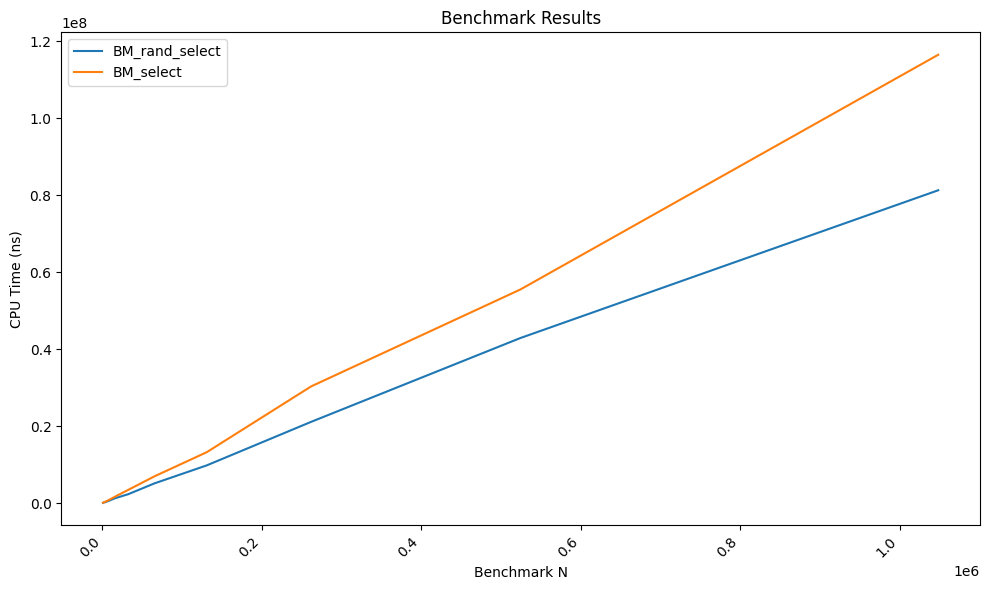

In [29]:
import json
import matplotlib.pyplot as plt

!cd select && make benchmark
print("")

# Load the JSON data
with open('select/benchmark.json', 'r') as f:
    data = json.load(f)

# Filter benchmark where run_type is iteration or mean aggregate
benchmarks = [
    benchmark for benchmark in data['benchmarks'] if
      benchmark['run_type'] == 'iteration' or
       (benchmark['run_type'] == 'aggregate' and benchmark['aggregate_name'] == 'mean')
]
# Sort benchmarks by name and N
benchmarks.sort(key=lambda x: (
    x['run_name'].split('/')[0],
    int(x['run_name'].split('/')[-1])
))

# Extract the relevant data for plotting
plots = {}
for benchmark in benchmarks:
    name = benchmark['run_name'].split('/')[0]
    N = int(benchmark['run_name'].split('/')[-1])

    if not name in plots:
      plots[name] = {}
      plots[name]['name'] = name
      plots[name]['x_values'] = [N]
      plots[name]['y_values'] = [float(benchmark['cpu_time'])]
    elif(N not in plots[name]['x_values']):
        plots[name]['x_values'].append(N)
        plots[name]['y_values'].append(float(benchmark['cpu_time']))

plt.figure(figsize=(10, 6))
for name, plot in plots.items():
    plt.plot(plot['x_values'], plot['y_values'], label=name)
plt.xlabel('Benchmark N')
plt.ylabel('CPU Time (ns)')
plt.title('Benchmark Results')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()